In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, dataset

In [2]:
seed = 1
torch.manual_seed(seed)

In [3]:
data_path = 'data/weatherHistory.csv'
df = pd.read_csv(data_path)

In [4]:
univariate_df = df['Temperature (C)']
univariate_df.index = df['Formatted Date']

In [5]:
input_size = 6
label_size = 1
offset = 1

def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
    features = []
    labels = []

    window_size = input_size + offset

    if df_end_idx == None:
        df_end_idx = len(df) - window_size

    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size
        label_start_idx = idx + window_size - label_size

        feature = df[idx:feature_end_idx]
        label = df[label_start_idx:(idx+window_size)]

        features.append(feature)
        labels.append(label)

    features = np.expand_dims(np.array(features), -1)
    labels = np.array(labels)

    return features, labels

In [6]:
dataset_length = len(univariate_df)
train_size = 0.7
val_size = 0.2
train_end_idx = int(train_size * dataset_length)
val_end_idx = int(val_size * dataset_length) + train_end_idx

X_train, y_train = slicing_window(
    univariate_df,
    df_start_idx=0,
    df_end_idx=train_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_val, y_val = slicing_window(
    univariate_df,
    df_start_idx=train_end_idx,
    df_end_idx=val_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_test, y_test = slicing_window(
    univariate_df,
    df_start_idx=val_end_idx,
    df_end_idx=None,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

In [7]:
class WeatherDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return X, y

In [8]:
train_dataset = WeatherDataset(X_train, y_train)
val_dataset = WeatherDataset(X_val, y_val)
test_dataset = WeatherDataset(X_test, y_test)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=True
)

In [9]:
class WeatherForecastor(nn.Module):
    def __init__(self, embedding_dim, hidden_size, n_layers, dropout_prob):
        super(WeatherForecastor, self).__init__()
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)

        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, hn = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.fc(x)

        return x

In [10]:
embedding_dim = 1
hidden_size = 8
n_layers = 3
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = WeatherForecastor(
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout_prob=dropout_prob
).to(device)

In [11]:
lr = 1e-3
epochs = 50

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)

In [12]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

In [13]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [14]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss: 124.7072	Val loss: 39.5492


EPOCH 2:	Train loss: 21.5177	Val loss: 6.2504


EPOCH 3:	Train loss: 5.5168	Val loss: 2.6380


EPOCH 4:	Train loss: 3.2202	Val loss: 1.8594


EPOCH 5:	Train loss: 2.6540	Val loss: 1.7115


EPOCH 6:	Train loss: 2.4681	Val loss: 1.5787


EPOCH 7:	Train loss: 2.3647	Val loss: 1.5714


EPOCH 8:	Train loss: 2.3046	Val loss: 1.6159


EPOCH 9:	Train loss: 2.2912	Val loss: 1.5513


EPOCH 10:	Train loss: 2.2578	Val loss: 1.6926


EPOCH 11:	Train loss: 2.2392	Val loss: 1.4999


EPOCH 12:	Train loss: 2.2292	Val loss: 1.5985


EPOCH 13:	Train loss: 2.2192	Val loss: 1.5304


EPOCH 14:	Train loss: 2.2069	Val loss: 1.5531


EPOCH 15:	Train loss: 2.2152	Val loss: 1.4526


EPOCH 16:	Train loss: 2.1887	Val loss: 1.5137


EPOCH 17:	Train loss: 2.1798	Val loss: 1.4832


EPOCH 18:	Train loss: 2.1828	Val loss: 1.4939


EPOCH 19:	Train loss: 2.1722	Val loss: 1.4592


EPOCH 20:	Train loss: 2.1682	Val loss: 1.4543


EPOCH 21:	Train loss: 2.1654	Val loss: 1.4515


EPOCH 22:	Train loss: 2.1607	Val loss: 1.4873


EPOCH 23:	Train loss: 2.1531	Val loss: 1.4971


EPOCH 24:	Train loss: 2.1590	Val loss: 1.5769


EPOCH 25:	Train loss: 2.1460	Val loss: 1.4694


EPOCH 26:	Train loss: 2.1483	Val loss: 1.4569


EPOCH 27:	Train loss: 2.1486	Val loss: 1.4301


EPOCH 28:	Train loss: 2.1455	Val loss: 1.4966


EPOCH 29:	Train loss: 2.1253	Val loss: 1.4351


EPOCH 30:	Train loss: 2.1344	Val loss: 1.4436


EPOCH 31:	Train loss: 2.1374	Val loss: 1.4366


EPOCH 32:	Train loss: 2.1276	Val loss: 1.4314


EPOCH 33:	Train loss: 2.1179	Val loss: 1.4584


EPOCH 34:	Train loss: 2.1100	Val loss: 1.4440


EPOCH 35:	Train loss: 2.1098	Val loss: 1.4325


EPOCH 36:	Train loss: 2.1096	Val loss: 1.4646


EPOCH 37:	Train loss: 2.1079	Val loss: 1.4620


EPOCH 38:	Train loss: 2.1166	Val loss: 1.4593


EPOCH 39:	Train loss: 2.1105	Val loss: 1.4289


EPOCH 40:	Train loss: 2.0989	Val loss: 1.4339


EPOCH 41:	Train loss: 2.1015	Val loss: 1.5322


EPOCH 42:	Train loss: 2.0958	Val loss: 1.4487


EPOCH 43:	Train loss: 2.0963	Val loss: 1.5092


EPOCH 44:	Train loss: 2.0953	Val loss: 1.5484


EPOCH 45:	Train loss: 2.0873	Val loss: 1.4657


EPOCH 46:	Train loss: 2.1025	Val loss: 1.4990


EPOCH 47:	Train loss: 2.0821	Val loss: 1.5441


EPOCH 48:	Train loss: 2.0830	Val loss: 1.4493


EPOCH 49:	Train loss: 2.0820	Val loss: 1.4672


EPOCH 50:	Train loss: 2.0810	Val loss: 1.4452


In [15]:
val_loss = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val loss: ', val_loss)
print('Test loss: ', test_loss)

Evaluation on val/test dataset
Val loss:  (1.4449675891186986, 0.005391394504924832)
Test loss:  (1.2225599582511855, 0.006639692914202718)


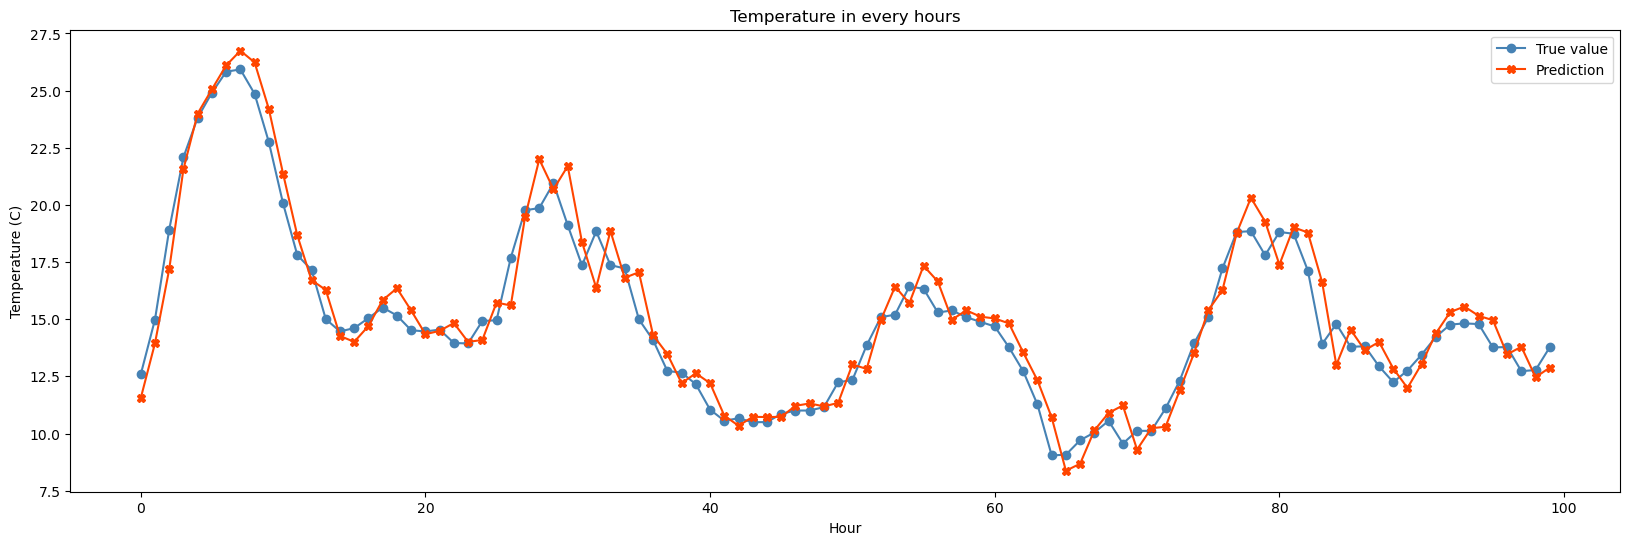

In [16]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')
    
    plt.title('Temperature in every hours')
    plt.xlabel('Hour')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.show()

inputs = torch.tensor(X_test[:100], dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    outputs = model(inputs).detach().cpu().numpy()

plot_difference(y_test[:100], outputs)